In [1]:
import torch
import torch.nn
import torch.nn.functional as F

In [2]:
from model.encoder import Encoder
from model.decoder import Decoder

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [4]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import skimage
from matplotlib import cm
import numpy as np
from dataset import get_dataset, collate_fn, vocab_size, int2char, char2int, SOS_CHAR, EOS_CHAR
from torch.utils.data import DataLoader
from torchvision import transforms
from utils import ScaleImageByHeight, PaddingWidth, AverageMeter, accuracy

In [7]:
config = {
    'batch_size': 32,
    'hidden_size': 256,
    'attn_size': 256,
    'max_length': 10,
    'n_epochs_decrease_lr': 15,
    'start_learning_rate': 1e-5,  # NOTE: paper start with 1e-8
    'end_learning_rate': 1e-11,
    'depth': 4,
    'n_blocks': 3,
    'growth_rate': 96,
}

In [8]:
MAX_LENGTH = config['max_length']
CKPT_DIR = './ckpt'

In [9]:
info = torch.load(os.path.join(CKPT_DIR, 'BEST_weights.pt'), map_location='cpu')

In [10]:
image_transform = transforms.Compose([
    transforms.Grayscale(3),
    ScaleImageByHeight(64),
    PaddingWidth(64),
    transforms.ToTensor(),
])

In [11]:
test_data = get_dataset('test', image_transform)
test_loader = DataLoader(test_data, batch_size=config['batch_size'], shuffle=False, collate_fn=collate_fn, num_workers=2)

In [12]:
encoder = Encoder(config['depth'], config['n_blocks'], config['growth_rate'])
if info['encoder_state'] is not None:
    encoder.load_state_dict(info['encoder_state'])

In [13]:
decoder = Decoder(encoder.n_features,
                  config['hidden_size'], vocab_size, config['attn_size'])
if info['decoder_state'] is not None:
    decoder.load_state_dict(info['decoder_state'])

In [14]:
encoder = encoder.to(device)
decoder = decoder.to(device)

In [15]:
encoder.eval()
decoder.eval();

In [16]:
test_iter = iter(test_loader)

In [17]:
imgs, targets, targets_onehot, lengths = next(test_iter)

In [18]:
imgs.size()

torch.Size([32, 3, 64, 198])

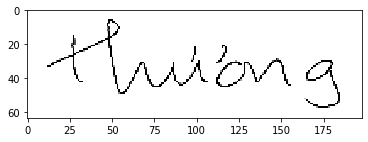

In [19]:
plt.imshow(imgs[0].squeeze().permute(1,2,0))

In [20]:
targets.size()

torch.Size([8, 32, 1])

In [21]:
''.join([int2char[x.item()] for x in targets[:,0].squeeze()])

'<start>thương<end>'

In [22]:
start_input = torch.zeros(1, config['batch_size'], vocab_size)
start_input[0,0, char2int[SOS_CHAR]] = 1
start_input = start_input.to(device)

In [23]:
with torch.no_grad():
#     for i, (imgs, targets, targets_onehot, lengths) in enumerate(val_loader):
    imgs = imgs.to(device)
    img_features = encoder(imgs)
    outputs, weights = decoder.greedy(img_features, start_input)

In [24]:
outputs.size()

torch.Size([10, 32, 150])

In [25]:
outputs

tensor([[[ 0.3217,  1.9388,  0.7247,  ..., -2.6622, -1.8956, -2.4173],
         [-0.5050,  1.5980,  0.2292,  ..., -2.7182, -1.9260, -2.5470],
         [-0.7438,  1.3178,  0.2521,  ..., -2.5934, -1.9595, -2.2914],
         ...,
         [-0.4201,  1.6645,  0.3806,  ..., -2.5863, -1.9598, -2.5551],
         [-0.7098,  2.0091,  0.3318,  ..., -2.3692, -2.0378, -2.3056],
         [-0.3839,  1.7454,  0.4149,  ..., -2.6335, -1.9430, -2.5016]],

        [[-1.5147,  2.2211,  0.1765,  ..., -2.6396, -2.6603, -2.7133],
         [-3.4795,  0.8296, -0.8782,  ..., -2.0795, -2.7557, -2.4567],
         [-1.4744,  1.6481,  0.6805,  ..., -2.2804, -2.0589, -2.0767],
         ...,
         [-1.3392,  3.1270,  1.0088,  ..., -0.9150, -1.2656, -2.2586],
         [-2.6775,  0.2742, -0.3382,  ..., -0.4393, -1.0438, -1.0020],
         [ 2.3135,  4.9120,  6.3203,  ..., -0.6933, -0.8653, -1.1373]],

        [[-4.3394, -2.6385, -2.5104,  ..., -2.2125, -3.7522, -3.1331],
         [-0.9668, -2.3155, -3.0134,  ..., -2

In [26]:
_, index = outputs.topk(1, -1)

In [27]:
index.size()

torch.Size([10, 32, 1])

In [28]:
predicts = index.squeeze().transpose(0, 1) # [B, T]
predicts_str = []
for predict in predicts:
    s = [int2char[x.item()] for x in predict]
    try:
        eos_index = s.index(EOS_CHAR) + 1
    except ValueError:
        eos_index = len(s)
    predicts_str.append(s[:eos_index])

predicts_str

[['<start>', 't', 'h', 'ư', 'ơ', 'n', 'g', '<end>'],
 ['<start>', 'h', 'u', 'y', 'ệ', 'n', '<end>'],
 ['<start>', 'T', 'h', 'à', 'n', 'h', '<end>'],
 ['<start>', 'n', 'g', 'ư', 'ờ', 'i', '<end>'],
 ['<start>', 't', 'ì', 'n', 'h', '<end>'],
 ['<start>', 'T', 'i', 'ê', 'n', '<end>'],
 ['<start>', 'L', 'ô', 'n', 'g', '<end>'],
 ['<start>', 'T', 'i', 'ê', 'n', '<end>'],
 ['<start>', 'b', 'o', 'n', 'g', '<end>'],
 ['<start>', 'c', 'h', 'â', 'u', '<end>'],
 ['<start>', 'T', 'm', 'n', '<end>'],
 ['<start>', 'g', 'i', 'à', '<end>'],
 ['<start>', 'n', 'ă', 'm', '<end>'],
 ['<start>', 'l', 'à', 'n', '<end>'],
 ['<start>', 'n', 'h', 'à', '<end>'],
 ['<start>', 'T', 'ô', 'i', '<end>'],
 ['<start>', 'g', 'á', 'p', '<end>'],
 ['<start>', 'ô', 'n', 'g', '<end>'],
 ['<start>', 'V', 'ă', 'n', '<end>'],
 ['<start>', 'T', 'á', 'm', '<end>'],
 ['<start>', 'n', 'g', 'y', '<end>'],
 ['<start>', 'B', 'ế', 'n', '<end>'],
 ['<start>', 'T', 'r', 'e', '<end>'],
 ['<start>', '3', '0', '<end>'],
 ['<start>', 'l', 

In [29]:
outputs2 = torch.nn.functional.softmax(outputs.transpose(0,1), dim=2)
outputs2

tensor([[[4.6545e-07, 2.3452e-06, 6.9648e-07,  ..., 2.3549e-08,
          5.0691e-08, 3.0084e-08],
         [4.5304e-06, 1.8992e-04, 2.4582e-05,  ..., 1.4711e-06,
          1.4409e-06, 1.3665e-06],
         [4.0804e-08, 2.2357e-07, 2.5411e-07,  ..., 3.4232e-07,
          7.3408e-08, 1.3634e-07],
         ...,
         [2.3987e-05, 9.7850e-06, 4.7290e-05,  ..., 4.5461e-06,
          9.1780e-07, 1.9249e-06],
         [4.0676e-06, 6.7631e-06, 1.5448e-05,  ..., 3.1350e-07,
          1.0964e-07, 1.2104e-07],
         [2.8555e-06, 4.9137e-06, 1.1243e-05,  ..., 3.5616e-07,
          9.3362e-08, 1.3018e-07]],

        [[1.9710e-07, 1.6143e-06, 4.1073e-07,  ..., 2.1552e-08,
          4.7594e-08, 2.5576e-08],
         [7.4894e-06, 5.5700e-04, 1.0096e-04,  ..., 3.0370e-05,
          1.5445e-05, 2.0828e-05],
         [1.1768e-05, 3.0547e-06, 1.5202e-06,  ..., 2.2671e-06,
          1.2908e-06, 9.3769e-07],
         ...,
         [1.1981e-06, 1.6907e-06, 5.2396e-06,  ..., 1.6824e-07,
          4.949

In [63]:
# beam search
def beam_search_decoder(data, k=3):
    res = []
    sequences = [[list(), 1.0]]
    for row in data:
        all_candidates = list()
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                candidate = [seq + [j], score * -torch.log(row[j])]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        sequences = ordered[:k]
        
        res += [x for x in sequences if x[0][-1] == char2int[EOS_CHAR]]
        sequences = [x for x in sequences if x[0][-1] != char2int[EOS_CHAR]]
        if len(res)==3:
            break
    return sorted(res, key=lambda tup:tup[1])[0][0]

In [64]:
predicts = [beam_search_decoder(o) for o in outputs2]
predicts_str = []
for predict in predicts:
    s = [int2char[x] for x in predict]
    try:
        eos_index = s.index(EOS_CHAR) + 1
    except ValueError:
        eos_index = len(s)
    predicts_str.append(s[:eos_index])

predicts_str

[['<start>', 't', 'h', 'ư', 'ơ', 'n', 'g', '<end>'],
 ['<start>', 'h', 'u', 'y', 'ệ', 'n', '<end>'],
 ['<start>', 'T', 'h', 'à', 'n', 'h', '<end>'],
 ['<start>', 'n', 'g', 'ư', 'ờ', 'i', '<end>'],
 ['<start>', 't', 'ì', 'n', 'h', 'h', '<end>'],
 ['<start>', 'T', 'i', 'ê', 'n', '<end>'],
 ['<start>', 'L', 'ô', 'n', 'g', '<end>'],
 ['<start>', 'T', 'i', 'ê', 'n', '<end>'],
 ['<start>', 'b', 'o', 'n', 'g', '<end>'],
 ['<start>', 'c', 'h', 'â', 'u', '<end>'],
 ['<start>', 'T', 'm', 'n', '<end>'],
 ['<start>', 'g', 'i', 'à', '<end>'],
 ['<start>', 'n', 'ă', 'm', '<end>'],
 ['<start>', 'l', 'à', 'n', '<end>'],
 ['<start>', 'n', 'h', 'à', '<end>'],
 ['<start>', 'T', 'ô', 'i', '<end>'],
 ['<start>', 'g', 'á', 'p', '<end>'],
 ['<start>', 'ô', 'n', 'g', '<end>'],
 ['<start>', 'V', 'ă', 'n', '<end>'],
 ['<start>', 'T', 'á', 'm', '<end>'],
 ['<start>', 'n', 'g', 'y', '<end>'],
 ['<start>', 'B', 'ế', 'n', '<end>'],
 ['<start>', 'T', 'r', 'e', '<end>'],
 ['<start>', '3', '0', '<end>'],
 ['<start>', 

In [27]:
weights.size()

torch.Size([10, 32, 48])

In [28]:
img_rows, img_cols = imgs.size(2), imgs.size(3)
print(img_rows, img_cols)

64 198


In [29]:
length = len(predicts)
length

32

# Visualize a sample

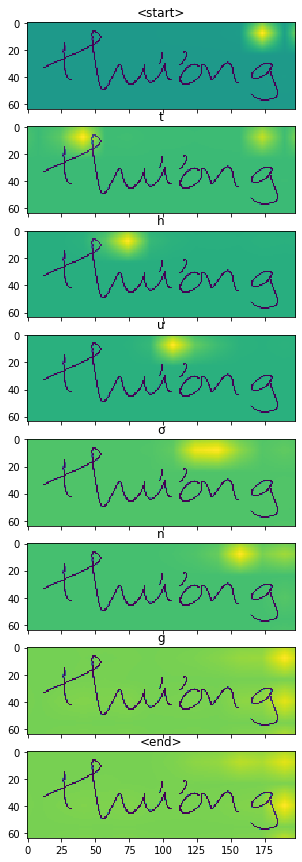

In [30]:
sample_index = 0
sample_image, sample_predict, sample_weigth = imgs[sample_index], predicts_str[sample_index], weights[:, [sample_index]]
fig, axeses = plt.subplots(len(sample_predict), figsize=(15,15), sharex=True, sharey=True)

for i, axes in enumerate(axeses.ravel()):
    weight = weights[i].reshape(-1, config['batch_size'], img_rows // 16, img_cols // 16) # 16 is factor that DenseNet reduce the original image size
    weight_numpy = weight.cpu().numpy()[:,sample_index,:].squeeze()
    weight_image = skimage.transform.resize(weight_numpy, (img_rows, img_cols))
    
    img = sample_image.squeeze().permute(1,2,0).cpu().numpy()[:,:,0]
    
    alpha = 0.5
    blend = img * alpha + weight_image * (1-alpha)
    
    axes.set_title(sample_predict[i])
    axes.imshow(blend)
plt.plot();

# Calc CER, WER on the test set

## CER

In [54]:
import editdistance as ed

In [55]:
from tqdm.notebook import tqdm

In [33]:
total_characters = 0
total_words = 0
CE = 0
WE = 0
log_interval = 10

t = tqdm(test_loader)
with torch.no_grad():
    for (imgs, targets, targets_onehot, lengths) in t:
        batch_size = imgs.size(0)
        
        start_input = torch.zeros(1, batch_size, vocab_size)
        start_input[0,0, char2int[SOS_CHAR]] = 1
        start_input = start_input.to(device)
        imgs = imgs.to(device)
        
        img_features = encoder(imgs)
        outputs, weights = decoder.greedy(img_features, start_input)
        
        _, index = outputs.topk(1, -1)
        predicts = index.squeeze().transpose(0, 1) # [B, T]
        predicts_str = []
        for predict in predicts:
            s = [int2char[x.item()] for x in predict]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            predicts_str.append(s[:eos_index])

        targets_str = []
        for target in targets.transpose(0, 1).squeeze():
            s = [int2char[x.item()] for x in target]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            targets_str.append(s[:eos_index])
        
        assert len(predicts_str) == len(targets_str)
        for i in range(len(predicts_str)):
            CE += ed.distance(predicts_str[i], targets_str[i])
        total_characters += lengths.sum().item()
        
        for i in range(len(predicts_str)):
            WE += 1 if np.array_equal(np.array(predicts_str[i]), np.array(targets_str[i])) else 0
        total_words += len(predicts_str)
        
        t.update()

In [34]:
CER = CE / total_characters
WER = WE / total_words
print('CER', CER)
print('WER', WER)

CER 0.13170666048501073
WER 0.5272944455504679


In [56]:
total_characters = 0
total_words = 0
CE = 0
WE = 0
log_interval = 10

t = tqdm(test_loader)
with torch.no_grad():
    for (imgs, targets, targets_onehot, lengths) in t:
        batch_size = imgs.size(0)
        
        start_input = torch.zeros(1, batch_size, vocab_size)
        start_input[0,0, char2int[SOS_CHAR]] = 1
        start_input = start_input.to(device)
        imgs = imgs.to(device)
        
        img_features = encoder(imgs)
        outputs, weights = decoder.greedy(img_features, start_input)
        
        outputs = torch.nn.functional.softmax(outputs.transpose(0,1), dim=2)
        
        predicts = [beam_search_decoder(output) for output in outputs]
        predicts_str = []
        for predict in predicts:
            s = [int2char[x] for x in predict]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            predicts_str.append(s[:eos_index])

        targets_str = []
        for target in targets.transpose(0, 1).squeeze():
            s = [int2char[x.item()] for x in target]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            targets_str.append(s[:eos_index])
        
        assert len(predicts_str) == len(targets_str)
        for i in range(len(predicts_str)):
            CE += ed.distance(predicts_str[i], targets_str[i])
        total_characters += lengths.sum().item()
        
        for i in range(len(predicts_str)):
            WE += 1 if np.array_equal(np.array(predicts_str[i]), np.array(targets_str[i])) else 0
        total_words += len(predicts_str)
        
        t.update()

In [57]:
CER = CE / total_characters
WER = WE / total_words
print('CER', CER)
print('WER', WER)

CER 0.1317515273426108
WER 0.5278518813458093
